In [ ]:
#Imports
import sys,os
from itertools import combinations
from functools import partial
import numpy as np
from time import time
import matplotlib.pyplot as plt
timestamp = time()

The general $\mathcal{U}$ matrix is given by $\begin{bmatrix}
\mathbf{U} & \mathbf{V*} \\
\mathbf{V} & \mathbf{U*}
\end{bmatrix}
$ representing the eigen values of the $2\times2$ matrix. The correlation and anomolous correlation functions are given by

$\mathbf{G}= \mathbf{U}\mathbf{U}^\dagger$ and $\mathbf{F}= \mathbf{U}\mathbf{V}^\dagger$

THIS NOTEBOOK WAS CREATED AND DESTROYED IN A DAY:

mostly everything has been moved to /src/single_particle_sector.py

THERE IS HOWEVER still the original calculation of xx (which may be faster) and zz here.

In [336]:
#The general $\mathcal{G}$ matrix is 
def Gi(psi):
    #General G matrix (In which G and F live)
    return psi @ psi.T.conj() 


def H_bdg(h, L, J):
    #Generating Hamiltonian
    A = np.zeros((L, L))
    B = np.zeros((L, L))

    for j in range(L):
        A[j, j] = 2 * h
    for j in range(L - 1):
        A[j, j + 1] = A[j + 1, j] = -J
        B[j, j + 1] = -J
        B[j + 1, j] = J

   # Antiperiodic boundary condition (ABC) introduces a minus sign

    A[0, L - 1] = A[L - 1, 0] = J
    B[L - 1, 0] = J
    B[0, L - 1] = -J

    # #Periodic 
    # A[0, L - 1] = A[L - 1, 0] = -J
    # B[L - 1, 0] = -J
    # B[0, L - 1] = J

    return 1/2*np.block([[A, B], [-B, -A]])

def h_t(t, tau, h0, hf):
    return h0 + (hf - h0) * (t / tau)


(0.0, 1.0)

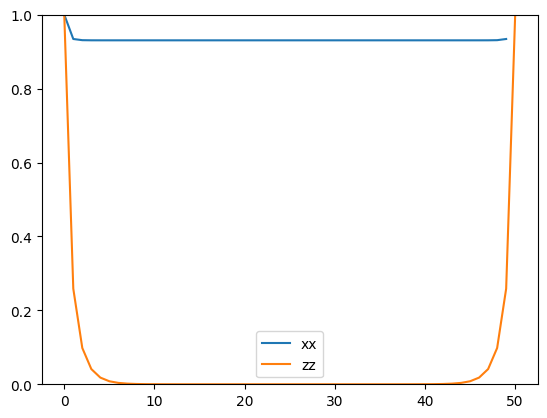

In [474]:
###Calculating Sigma_zz, sigma_xx ####
#Params
L = 50
J =-1
h = 1/2


E1, U1_full = np.linalg.eigh(H_bdg(h, L,J))
U1 = U1_full[:, :L]         # only negative-energy modes
G = Gi(U1)                  # full 2L × 2L correlation matrix
G1 = G[:L, :L]              # ⟨c† c⟩
F1 = G[:L, L:]              # ⟨c c⟩
M_t = np.eye(L)-2*(G1+F1)


n = np.arange(L+1)
zz = []
for ni in n:
    M = np.zeros((ni, ni), dtype=np.complex128)
    for j in range(ni):
        for jp in range(ni):
            s = int(j == jp)
            s += -2 * G1[j, jp]
            s += -2 * F1[j, jp]
            M[j, jp] = s
    zz.append(np.linalg.det(M))
j1 = 0
xx = []
for j2 in range(L):
    n = j2 - j1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
        for y in range(n):
            C[x, y] = M_t[j1 + x, j1 + 1 + y]
    xx.append(np.linalg.det(C))


plt.plot(xx,label = "xx")
plt.plot(zz,label = "zz")
#plt.plot(yy,label="yy")

plt.legend()
plt.ylim(0,1)


Adiabatic Tests:


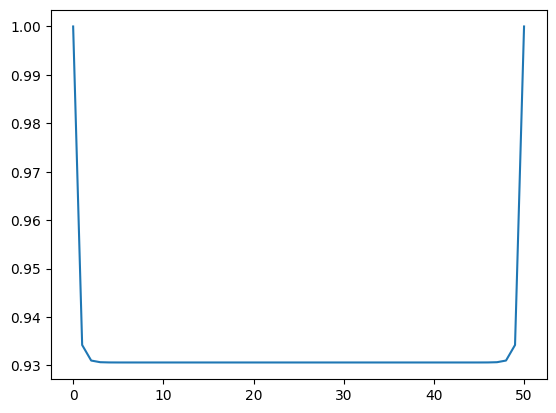

In [338]:



j1 = 0
xx = []
for j2 in range(L+1):
    n = (j2 - j1) % L
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
        for y in range(n):
            i = (j1 + x) % L
            j = (j1 + 1 + y) % L
            C[x, y] = M_t[i, j]
    xx.append(np.linalg.det(C))


plt.plot(xx,label = "xx")

In [339]:
pt = np.asarray(U1_full, dtype=np.complex128)
T = H_bdg_t
dat1 = [pt.copy()]
U = pt[:, :L]  # initial negative-energy modes
U = np.asarray(U, dtype=np.complex128)
xxx=[]
for t in times:
        H = H_bdg(h_t(t, tau, h0, hf), L,J)
        # U += -2j * H @ U * dt
        I = np.eye(2*L)
        A = I + 0.5j * dt * H
        B = I - 0.5j * dt * H
        U = np.linalg.solve(A, B @ U)
        G = Gi(U)                  # full 2L × 2L correlation matrix
        G1 = G[:L, :L]              # ⟨c† c⟩
        F1 = G[:L, L:]              # ⟨c c⟩
        M_t = np.eye(L)-2*(G1+F1)
        j1 = 0
        xx = []
        for j2 in range(L):
                n = j2 - j1
                C = np.zeros((n, n), dtype=np.complex128)
                for x in range(n):
                        for y in range(n):
                                C[x, y] = M_t[j1 + x, (j1 + 1 + y)]
                xx.append(np.linalg.det(C))
        xxx.append(xx)

        # Optional stabilization:
        # U, _ = np.linalg.qr(U)


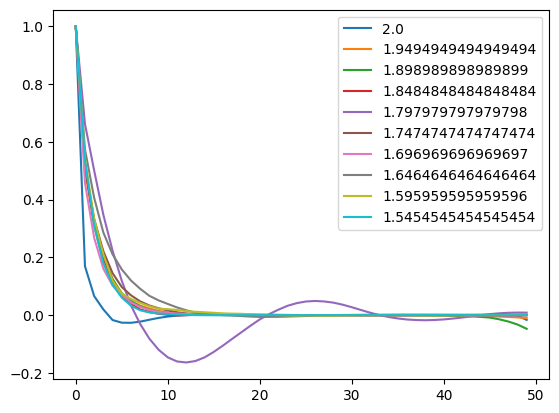

In [340]:
for i in range(0,len(xxx),10):
    plt.plot(xxx[i],label = h_t(times[i],tau,h0,hf))
plt.legend()

Computing Projectors:

We would like a code to systematically measure $\braket{P_n}$, from which we can conduct our studies. 


As we know, only even terms will contribute. So we can look at correlations of the form

 $$\braket{\sigma^x_{j_1} \sigma^x_{j_2} \sigma^x_{j_3} \sigma^x_{j_4}} =B_i A_{j+1} B_{j+1}...A_{j_2-1}B_{j_2-1}A_{j_2} B_{j_3}...A_{j_4}$$

In [421]:
#First we will prepare all the hamiltonians we need:

J =-1
L = 50
tau = 100
N_steps = 100
times,dt= np.linspace(0,tau,N_steps,retstep=True)
h0 = 0.5
hf = 1.5
H_bdg_t = [H_bdg(h_t(ti, tau, h0,hf), L,J) for ti in times]
#Compute G and F 

E1, U_full = np.linalg.eigh(H_bdg_t[0])
U = U_full[:, :L]         # only negative-energy modes
G = Gi(U)                  # full 2L × 2L correlation matrix
G1 = G[:L, :L]              # ⟨c† c⟩
F1 = G[:L, L:]              # ⟨c c⟩
M_t = np.eye(L)-2*(G1+F1)

In [342]:
#Test Functions, tocehck the condition sof AA BB BA AB as given by eq(239-242)

def AA(Gi):
    L = np.shape(Gi)[0]//2
    G = Gi[:L,:L]
    F = Gi[:L,L:]
    return G+(np.eye(L)-G.T)+F+F.T.conj()
def BB(Gi):
    L = np.shape(Gi)[0]//2
    G = Gi[:L,:L]
    F = Gi[:L,L:]
    return -G-(np.eye(L)-G.T)+F+F.T.conj()
def AB(Gi):
    L = np.shape(Gi)[0]//2
    G = Gi[:L,:L]
    F = Gi[:L,L:]
    return G-(np.eye(L)-G.T)-F+F.T.conj()
def BA(Gi):
    L = np.shape(Gi)[0]//2
    G = Gi[:L,:L]
    F = Gi[:L,L:]
    return -G+(np.eye(L)-G.T)-F+F.T.conj()


In [345]:
####TIME EVOLUTION#####

from scipy.integrate import solve_ivp

def rhs(t, U_flat, h_t, tau, h0, hf, J):
    
    U = U_flat.reshape(2*L, 2*L)

    H = H_bdg(h_t(t, tau, h0, hf), L, J)

    dUdt = -1j * 2 * H @ U

    return dUdt.flatten()


h0=2
hf = 1
tau = 100
N_steps = 1000
E1, U_full = np.linalg.eigh(H_bdg(h_t(0,tau,h0,hf),L,J))

##Time Evolution

U0 = U_full.astype(np.complex128)     # shape (2L, 2L)
args = (h_t, tau, h0, hf, J)
t_grid = np.linspace(0, tau, N_steps)
sol = solve_ivp(rhs, [0, tau], U0.flatten(), args=args, t_eval=t_grid, method="RK45", vectorized=False, dtype=np.complex128)

#U_t = sol.y.T.reshape(-1, 2*L, 2*L)  # shape (N_times, 2L, 2L)
U_t = np.array([sol.y[:, i].reshape(2*L, 2*L) for i in range(len(sol.t))])

print(sol.success, sol.message)


True The solver successfully reached the end of the integration interval.


(0.0, 50.0)

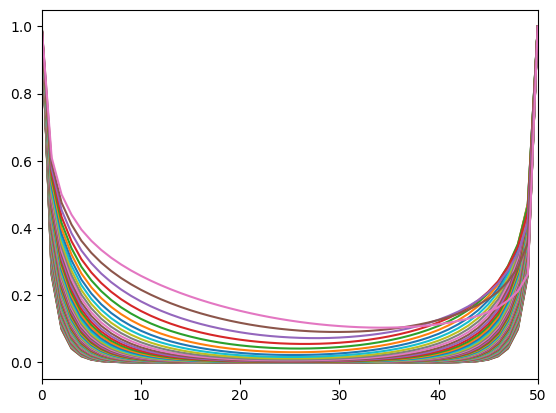

In [346]:

for i in range(0,len(U_t),15):
    U = U_t[i][:, :L]         # only negative-energy modes
    G = Gi(U)                  # full 2L × 2L correlation matrix
    G1 = G[:L, :L]              # ⟨c† c⟩
    F1 = G[:L, L:]              # ⟨c c⟩
    M_t = np.eye(L)-2*(G1+F1)
    j1 = 0
    xx = []
    for j2 in range(L+1):
        n = (j2 - j1) % L
        C = np.zeros((n, n), dtype=np.complex128)
        for x in range(n):
            for y in range(n):
                i = (j1 + x) % L
                j = (j1 + 1 + y) % L
                C[x, y] = M_t[i, j]
        xx.append(np.linalg.det(C))

    

    plt.plot(xx,label = "xx")
plt.xlim(0,L)
#plt.ylim(0,1.1)

In [210]:
def pfaffian(A):
    n = A.shape[0]
    if n % 2 != 0:
        return 0.0
    A = A.copy()
    pf = 1.0
    for i in range(0, n-1, 2):
        if A[i+1, i] == 0:
            for j in range(i+2, n):
                if A[j, i] != 0:
                    A[[i+1, j]] = A[[j, i+1]]
                    A[:, [i+1, j]] = A[:, [j, i+1]]
                    pf *= -1
                    break
        if A[i+1, i] == 0:
            return 0.0
        pf *= A[i+1, i]
        for j in range(i+2, n):
            for k in range(i+2, n):
                A[j, k] -= (A[i, j]*A[i+1, k] - A[i, k]*A[i+1, j]) / A[i+1, i]
    return pf


In [ ]:
h_i = np.linspace(0,2,1000)
xxxx =[]
xx1 = []
xx2 = []
xx3 = []
test =[]
for h0 in h_i:
    J =-1
    L = 50
    tau = 100
    N_steps = 100
    times,dt= np.linspace(0,tau,N_steps,retstep=True)

    hf = 1.5
    E1, U1_full = np.linalg.eigh(H_bdg(h0,L,J))
    U1 = U1_full[:, :L]         # only negative-energy modes
    G = Gi(U1)                  # full 2L × 2L correlation matrix
    G1 = G[:L, :L]              # ⟨c† c⟩
    F1 = G[:L, L:]              # ⟨c c⟩
    M_t = np.eye(L)-2*(G1+F1)

    positions = [1, 2,3,4]  # must be sorted
    n = len(positions)

    Gamma = np.zeros((n, n), dtype=np.complex128)
    for a in range(n):
        for b in range(n):
            if a < b:
                Gamma[a, b] = M_t[positions[a], positions[b]]
                Gamma[b, a] = -Gamma[a, b]

    result = pfaffian(Gamma)
    xxxx.append(result)

    n = 1
    ji = 1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
            for y in range(n):
                    C[x, y] = M_t[j1 + x, (j1 + 1 + y)]
    xx1.append(np.linalg.det(C))
    
    n = 2
    ji = 1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
            for y in range(n):
                    C[x, y] = M_t[j1 + x, (j1 + 1 + y)]
    xx2.append(np.linalg.det(C))

    n = 3
    ji = 1
    C = np.zeros((n, n), dtype=np.complex128)
    for x in range(n):
            for y in range(n):
                    C[x, y] = M_t[j1 + x, (j1 + 1 + y)]
    xx3.append(np.linalg.det(C))
   



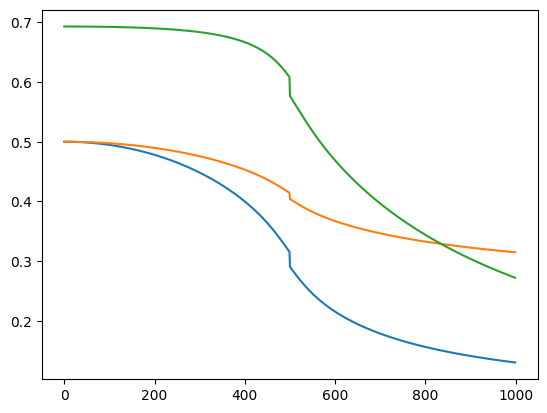

In [327]:


P2 = (np.array(xx1)+1)/4
xxxx =np.array(xxxx)
xx1 = np.array(xx1)
xx2 = np.array(xx2)
xx3 = np.array(xx3)
P4 = 1/16*(1+ 3*xx1+2*xx2+xx3+xxxx)
plt.plot(P4)
plt.plot(P2)

plt.plot( np.log(P4/P2**2))

In [503]:
def sigma_general(indices):
    indices = np.sort(indices)
    if len(indices)%2 == 1:
        return 0
    
    def remove_duplicates_in_pairs(vec):
        unique_vals, counts = np.unique(vec, return_counts=True)
        filtered_vals = unique_vals[counts % 2 != 0]
        return filtered_vals.tolist()
    indices = remove_duplicates_in_pairs(indices)
    if len(indices)==0:
        return 1
    
    string_list = []
    for i in range(len(indices)):
        if i%2==0:
            string_list.append([indices[i],"B"])
        else:
            string_list.append([indices[i],"A"])
    
    for i in range(0,len(indices),2):

        for a in range(indices[i]+1,indices[i+1]):
            string_list.append([a,"A"])
            string_list.append([a,"B"])
    
    
    return string_list
    


def construct_M_matrix(fermion_operators, correlation_function,G):
    """
    fermion_operators: list of tuples (site index, operator type)
    t: time
    correlation_function: function taking (op1, op2, t) and returning ⟨f_i f_j⟩
    """
    l = len(fermion_operators)
    M = np.zeros((l, l), dtype=complex)

    for mu in range(l):
        for nu in range(mu + 1, l):
            op1 = fermion_operators[mu]
            op2 = fermion_operators[nu]
            val = correlation_function(op1, op2,G)
            M[mu, nu] = val
            M[nu, mu] = -val

    return M


def correlation_function(op_string_1, op_string_2, G):
    i, op1 = op_string_1
    j, op2 = op_string_2
    if op1 == "A" and op2 == "A":
        return AA(G)[i,j]
    elif op1 == "B" and op2 == "B":
        return BB(G)[i,j]
    elif op1 == "A" and op2 == "B":
        return AB(G)[i,j]
    elif op1 == "B" and op2 == "A":

        return BA(G)[i,j]


/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


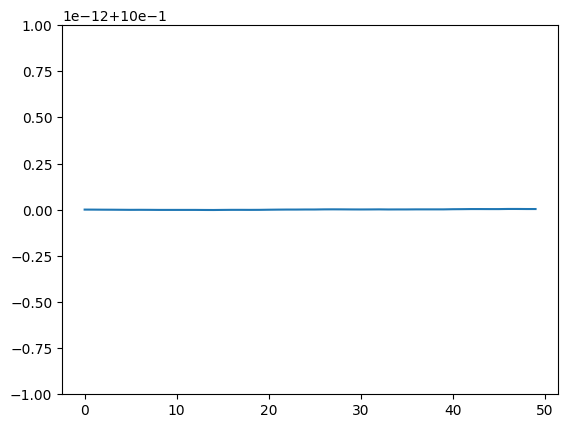

In [520]:
dat= []

h0 = 0
E1, U1_full = np.linalg.eigh(H_bdg(h0,L,J))
U1 = U1_full[:, :L]         # only negative-energy modes
G = Gi(U1)         
for i in range(0,L):
    x = sigma_general([0,int(i)])

    if x ==1:
        dat.append(x)
    else:
        dat.append(np.linalg.det(construct_M_matrix(x,correlation_function,G))**(1/2))
plt.plot(dat)
#plt.plot(xx)


In [544]:
from itertools import combinations

def binomial_expansion(indices):
    """
    Computes the pairs of combinations of indices.
    """
    pairs = list(combinations(indices, 2))
    return pairs

def all_combinations(indices):
    """
    Computes all combinations of all lengths of indices.
    """
    x = []
    for r in range(len(indices) + 1):
        x.extend(combinations(indices, r))
    return list(x)

h_i = np.linspace(0,2)
data2 = []
for h0 in h_i:
    L = 50

    times,dt= np.linspace(0,tau,N_steps,retstep=True)

    E1, U1_full = np.linalg.eigh(H_bdg(h0,L,J))
    U1 = U1_full[:, :L]         # only negative-energy modes
    G = Gi(U1)                  # full 2L × 2L correlation matrix
    
    terms = all_combinations([1,2,3,4,5])
    dat = []
    for term in terms:
        x = sigma_general(term)
        if x ==1 or x==0:
            dat.append(x)
        else:
            dat.append(np.linalg.det(construct_M_matrix(x,correlation_function,G))**(1/2))
    data2.append(np.mean(dat))

/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


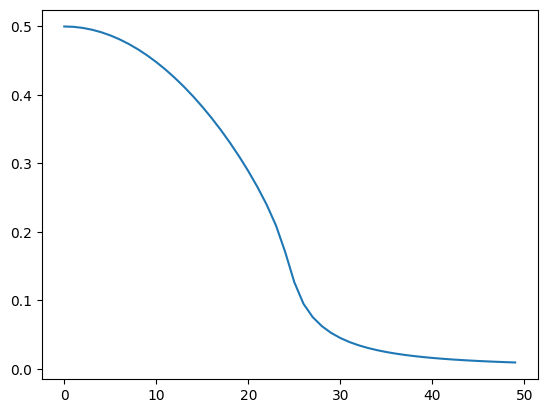

In [ ]:
plt.plot(data4)


/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


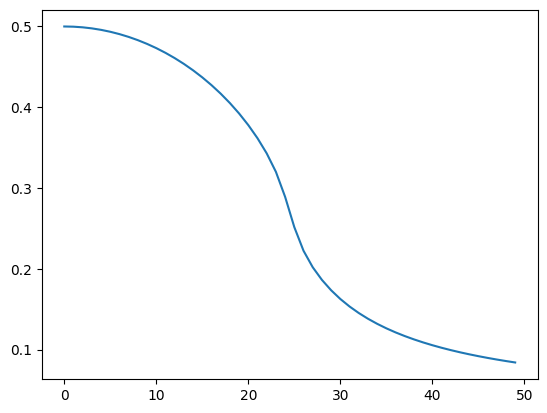

In [545]:
plt.plot(data2)